# Bouw een classificatiemodel: Heerlijke Aziatische en Indiase Keukens


## Culinair classificeren 1

In deze les gaan we een verscheidenheid aan classificatiemethoden verkennen om *een nationale keuken te voorspellen op basis van een groep ingrediënten.* Terwijl we dit doen, leren we meer over hoe algoritmes kunnen worden ingezet voor classificatietaken.

### [**Pre-lecture quiz**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Voorbereiding**

Deze les bouwt voort op onze [vorige les](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) waarin we:

-   Een eenvoudige introductie gaven tot classificaties met behulp van een dataset over alle geweldige keukens van Azië en India 😋.

-   Enkele [dplyr-werkwoorden](https://dplyr.tidyverse.org/) onderzochten om onze data voor te bereiden en schoon te maken.

-   Prachtige visualisaties maakten met ggplot2.

-   Lieten zien hoe om te gaan met onevenwichtige data door deze te preprocessen met behulp van [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demonstreerden hoe we onze `prep` en `bake` konden gebruiken om te bevestigen dat het werkt zoals bedoeld.

#### **Vereisten**

Voor deze les hebben we de volgende pakketten nodig om onze data schoon te maken, voor te bereiden en te visualiseren:

-   `tidyverse`: Het [tidyverse](https://www.tidyverse.org/) is een [verzameling van R-pakketten](https://www.tidyverse.org/packages) ontworpen om datawetenschap sneller, eenvoudiger en leuker te maken!

-   `tidymodels`: Het [tidymodels](https://www.tidymodels.org/) framework is een [verzameling van pakketten](https://www.tidymodels.org/packages/) voor modellering en machine learning.

-   `themis`: Het [themis-pakket](https://themis.tidymodels.org/) biedt extra stappen in recepten om om te gaan met onevenwichtige data.

-   `nnet`: Het [nnet-pakket](https://cran.r-project.org/web/packages/nnet/nnet.pdf) biedt functies voor het schatten van feed-forward neurale netwerken met een enkele verborgen laag, en voor multinomiale logistische regressiemodellen.

Je kunt ze installeren als:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Als alternatief controleert het onderstaande script of je de pakketten hebt die nodig zijn om deze module te voltooien en installeert ze voor je als ze ontbreken.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Verdeel de data in trainings- en testsets.

We beginnen met een paar stappen uit onze vorige les.

### Laat de meest voorkomende ingrediënten weg die verwarring veroorzaken tussen verschillende keukens, met behulp van `dplyr::select()`.

Iedereen houdt van rijst, knoflook en gember!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfect! Nu is het tijd om de gegevens te splitsen, zodat 70% van de gegevens naar training gaat en 30% naar testen. We zullen ook een `stratificatie`-techniek toepassen bij het splitsen van de gegevens om `de proportie van elke keuken` in de trainings- en validatiedatasets te behouden.

[rsample](https://rsample.tidymodels.org/), een pakket in Tidymodels, biedt infrastructuur voor efficiënte gegevenssplitsing en resampling:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Omgaan met onevenwichtige data

Zoals je misschien hebt opgemerkt in de oorspronkelijke dataset en in onze trainingsset, is er een behoorlijk ongelijke verdeling in het aantal keukens. Koreaanse keukens zijn *bijna* 3 keer zoveel als Thaise keukens. Onevenwichtige data heeft vaak een negatieve invloed op de prestaties van het model. Veel modellen presteren het beste wanneer het aantal observaties gelijk is en hebben daarom moeite met onevenwichtige data.

Er zijn grofweg twee manieren om met onevenwichtige datasets om te gaan:

-   Observaties toevoegen aan de minderheidscategorie: `Over-sampling`, bijvoorbeeld met behulp van een SMOTE-algoritme dat synthetisch nieuwe voorbeelden van de minderheidscategorie genereert door gebruik te maken van de dichtstbijzijnde buren van deze gevallen.

-   Observaties verwijderen uit de meerderheidscategorie: `Under-sampling`

In onze vorige les hebben we gedemonstreerd hoe je met onevenwichtige datasets kunt omgaan met behulp van een `recipe`. Een recipe kan worden gezien als een blauwdruk die beschrijft welke stappen moeten worden toegepast op een dataset om deze klaar te maken voor data-analyse. In ons geval willen we een gelijke verdeling in het aantal keukens in onze `trainingsset`. Laten we meteen aan de slag gaan.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Je kunt natuurlijk doorgaan en bevestigen (door voor te bereiden en te bakken) dat het recept werkt zoals je verwacht - alle keukentags hebben `559` observaties.

Aangezien we dit recept als een voorverwerker voor modellering zullen gebruiken, zal een `workflow()` al het voorbereiden en bakken voor ons doen, zodat we het recept niet handmatig hoeven te schatten.

Nu zijn we klaar om een model te trainen 👩‍💻👨‍💻!

## 3. Het kiezen van je classifier

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Kunstwerk door @allison_horst</figcaption>


Nu moeten we beslissen welk algoritme we gaan gebruiken voor de taak 🤔.

In Tidymodels biedt de [`parsnip package`](https://parsnip.tidymodels.org/index.html) een consistente interface voor het werken met modellen over verschillende engines (pakketten). Raadpleeg de parsnip-documentatie om [modeltypes en engines](https://www.tidymodels.org/find/parsnip/#models) en hun bijbehorende [modelargumenten](https://www.tidymodels.org/find/parsnip/#model-args) te verkennen. De variëteit kan in eerste instantie behoorlijk overweldigend zijn. Bijvoorbeeld, de volgende methoden omvatten allemaal classificatietechnieken:

-   C5.0 Regelgebaseerde classificatiemodellen

-   Flexibele discriminantmodellen

-   Lineaire discriminantmodellen

-   Geregulariseerde discriminantmodellen

-   Logistische regressiemodellen

-   Multinomiale regressiemodellen

-   Naïve Bayes-modellen

-   Support Vector Machines

-   Nabijheid van buren

-   Beslissingsbomen

-   Ensemblemethoden

-   Neurale netwerken

De lijst gaat maar door!

### **Welke classifier kiezen?**

Dus, welke classifier moet je kiezen? Vaak is het testen van meerdere classifiers en zoeken naar een goed resultaat een manier om te experimenteren.

> AutoML lost dit probleem handig op door deze vergelijkingen in de cloud uit te voeren, zodat je het beste algoritme voor jouw data kunt kiezen. Probeer het [hier](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Daarnaast hangt de keuze van classifier af van ons probleem. Bijvoorbeeld, wanneer de uitkomst kan worden gecategoriseerd in `meer dan twee klassen`, zoals in ons geval, moet je een `multiclass classificatie-algoritme` gebruiken in plaats van een `binaire classificatie.`

### **Een betere aanpak**

Een betere manier dan willekeurig gokken is echter om de ideeën te volgen op dit downloadbare [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Hier ontdekken we dat, voor ons multiclass probleem, we enkele keuzes hebben:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Een gedeelte van Microsoft's Algorithm Cheat Sheet, met opties voor multiclass classificatie</figcaption>


### **Redenering**

Laten we kijken of we verschillende benaderingen kunnen overwegen binnen de beperkingen die we hebben:

-   **Diepe neurale netwerken zijn te zwaar**. Gezien onze schone, maar minimale dataset, en het feit dat we lokaal via notebooks trainen, zijn diepe neurale netwerken te zwaar voor deze taak.

-   **Geen tweeklassen-classificator**. We gebruiken geen tweeklassen-classificator, dus dat sluit one-vs-all uit.

-   **Beslissingsboom of logistische regressie zou kunnen werken**. Een beslissingsboom zou kunnen werken, of multinomiale regressie/multiklassen logistische regressie voor multiklassen data.

-   **Multiklassen Boosted Decision Trees lossen een ander probleem op**. De multiklassen boosted decision tree is het meest geschikt voor niet-parametrische taken, bijvoorbeeld taken die bedoeld zijn om ranglijsten te maken, dus het is niet nuttig voor ons.

Bovendien is het normaal gesproken een goed idee om, voordat je aan complexere machine learning-modellen zoals ensemble-methoden begint, het eenvoudigste model te bouwen om een idee te krijgen van wat er aan de hand is. Dus voor deze les beginnen we met een `multinomiale regressie`-model.

> Logistische regressie is een techniek die wordt gebruikt wanneer de uitkomstvariabele categorisch (of nominaal) is. Voor binaire logistische regressie is het aantal uitkomstvariabelen twee, terwijl het aantal uitkomstvariabelen voor multinomiale logistische regressie meer dan twee is. Zie [Advanced Regression Methods](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) voor meer informatie.

## 4. Train en evalueer een multinomiaal logistisch regressiemodel.

In Tidymodels definieert `parsnip::multinom_reg()` een model dat lineaire voorspellers gebruikt om multiklassen data te voorspellen met behulp van de multinomiale verdeling. Zie `?multinom_reg()` voor de verschillende manieren/engines die je kunt gebruiken om dit model te trainen.

Voor dit voorbeeld passen we een multinomiaal regressiemodel toe via de standaard [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) engine.

> Ik heb een waarde voor `penalty` min of meer willekeurig gekozen. Er zijn betere manieren om deze waarde te kiezen, namelijk door gebruik te maken van `resampling` en het model te `tunen`, wat we later zullen bespreken.
>
> Zie [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/) als je meer wilt leren over het tunen van modelhyperparameters.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Goed gedaan 🥳! Nu we een recept en een modelspecificatie hebben, moeten we een manier vinden om ze samen te bundelen in een object dat eerst de gegevens zal voorbewerken, vervolgens het model op de voorbewerkte gegevens zal passen en ook ruimte biedt voor mogelijke nabewerkingsactiviteiten. In Tidymodels wordt dit handige object een [`workflow`](https://workflows.tidymodels.org/) genoemd en het bevat op een handige manier je modelcomponenten! Dit is wat we in *Python* *pipelines* zouden noemen.

Dus laten we alles bundelen in een workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Workflows 👌👌! Een **`workflow()`** kan op vrijwel dezelfde manier worden aangepast als een model. Dus, tijd om een model te trainen!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

De output toont de coëfficiënten die het model heeft geleerd tijdens de training.

### Evalueer het getrainde model

Het is tijd om te zien hoe het model heeft gepresteerd 📏 door het te evalueren op een testset! Laten we beginnen met het maken van voorspellingen op de testset.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Goed gedaan! In Tidymodels kan de modelprestatie worden geëvalueerd met behulp van [yardstick](https://yardstick.tidymodels.org/) - een pakket dat wordt gebruikt om de effectiviteit van modellen te meten met prestatie-indicatoren. Zoals we deden in onze les over logistische regressie, laten we beginnen met het berekenen van een verwarringsmatrix.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Bij het werken met meerdere klassen is het over het algemeen intuïtiever om dit te visualiseren als een warmtekaart, zoals dit:


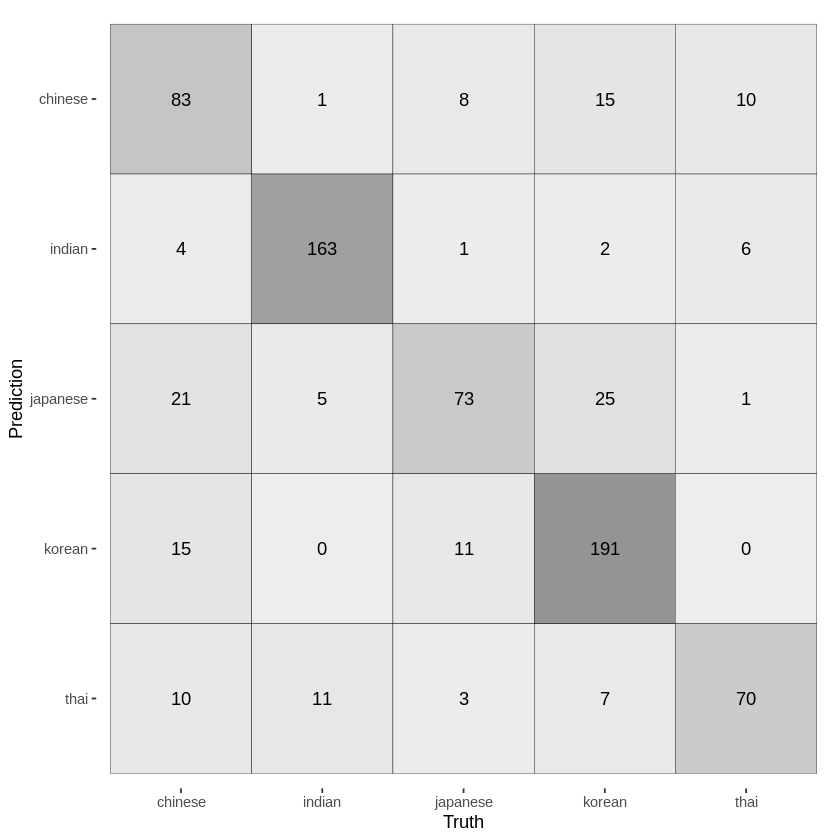

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

De donkere vierkanten in de plot van de verwarringsmatrix geven hoge aantallen gevallen aan, en hopelijk zie je een diagonale lijn van donkere vierkanten die gevallen aangeven waarbij het voorspelde en werkelijke label hetzelfde zijn.

Laten we nu samenvattende statistieken berekenen voor de verwarringsmatrix.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Als we ons beperken tot enkele statistieken zoals nauwkeurigheid, sensitiviteit, ppv, dan zijn we niet slecht begonnen 🥳!

## 4. Dieper Graven

Laten we een subtiele vraag stellen: Welke criteria worden gebruikt om een bepaald type keuken als voorspelde uitkomst te kiezen?

Nou, statistische machine learning-algoritmen, zoals logistische regressie, zijn gebaseerd op `waarschijnlijkheid`; wat een classifier daadwerkelijk voorspelt, is dus een waarschijnlijkheidsverdeling over een reeks mogelijke uitkomsten. De klasse met de hoogste waarschijnlijkheid wordt vervolgens gekozen als de meest waarschijnlijke uitkomst voor de gegeven observaties.

Laten we dit in de praktijk bekijken door zowel harde klassevoorspellingen als waarschijnlijkheden te maken.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Veel beter!

✅ Kun je uitleggen waarom het model er vrij zeker van is dat de eerste observatie Thais is?

## **🚀Uitdaging**

In deze les heb je je opgeschoonde data gebruikt om een machine learning-model te bouwen dat een nationale keuken kan voorspellen op basis van een reeks ingrediënten. Neem de tijd om de [vele opties](https://www.tidymodels.org/find/parsnip/#models) te bekijken die Tidymodels biedt om data te classificeren en [andere manieren](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) om multinomiale regressie toe te passen.

#### DANK AAN:

[`Allison Horst`](https://twitter.com/allison_horst/) voor het maken van de geweldige illustraties die R toegankelijker en aantrekkelijker maken. Vind meer illustraties in haar [galerij](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) en [Jen Looper](https://www.twitter.com/jenlooper) voor het maken van de originele Python-versie van deze module ♥️

<br>
Had wat grappen willen maken, maar ik snap geen voedselwoordspelingen 😅.

<br>

Veel leerplezier,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Disclaimer**:  
Dit document is vertaald met behulp van de AI-vertalingsservice [Co-op Translator](https://github.com/Azure/co-op-translator). Hoewel we streven naar nauwkeurigheid, dient u zich ervan bewust te zijn dat geautomatiseerde vertalingen fouten of onnauwkeurigheden kunnen bevatten. Het originele document in zijn oorspronkelijke taal moet worden beschouwd als de gezaghebbende bron. Voor cruciale informatie wordt professionele menselijke vertaling aanbevolen. Wij zijn niet aansprakelijk voor eventuele misverstanden of verkeerde interpretaties die voortvloeien uit het gebruik van deze vertaling.
